## Summer 2022 Data Science Intern Challenge at Shopify
### by Sarwari Das


Question 1: Given some sample data, write a program to answer the following:

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
What metric would you report for this dataset?
What is its value?


## Summary

As a product, we can imagine that sneakers are being ordered in two ways:
- by individual consumers who intend to use them for their personal lives
- by resellers who intend to sell them to other customers for profit

The AOV measures the average amount spent by a customer for any given order. Assuming that most sneaker orders on Shopify fall into the first category, we expect this to reflect the average for category one. However, our calculated AOV is $3145.13. Intuitively, this means that the price is being driven up due to the orders present in category two, and the measure of central tendency we have chosen to represent the AOV isn't doing a good enough job of ignoring those. Since the mean is highly sensitive to outliers, reporting it as a measure of a typical customer's average order is definitely erroneous. 

On examining the dataset, I found that the order amounts range between \$90 and \$704,000, with 75% of orders priced less than $390. The number of items purchased per order range between 1 and 2000, where 75% of orders are of less than 3 items. Hence we can say that our assumption of most orders coming from category 1 holds true. However, the mean is being impacted by those buyers who are ordering 2000 shoes at once. To remedy this, we can report average order amount as a median.

#### Reading data

In [139]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import altair as alt

df = pd.read_csv(os.getcwd() + "/00_source_data/data.csv", parse_dates=["created_at"])
df["date"] = df.created_at.dt.date
# df.info()
df.sample(5)


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,date
3216,3217,21,868,142,1,credit_card,2017-03-19 00:25:36,2017-03-19
69,70,58,876,138,1,debit,2017-03-04 10:38:49,2017-03-04
4563,4564,20,995,254,2,credit_card,2017-03-03 11:48:24,2017-03-03
1708,1709,98,956,266,2,credit_card,2017-03-20 10:53:58,2017-03-20
258,259,75,760,512,4,cash,2017-03-18 08:19:53,2017-03-18


#### Exploring the data

1. Sanity checks: 
- Check number of unique sneaker shops
- Check for nulls in data
- Check datatypes of columns
- Reproduce AOV of $3145.13 for 30 day period
- Do most orders come from individual buyers or resellers?

In [140]:
assert df.shop_id.nunique() == 100  # 100 shops as mentioned in the problem
assert (
    df.date.nunique() == 30
)  # There are 30 days in total, we don't need to subset the data
df.isna().sum()  # no null values across columns
df.dtypes  # datatypes are as expected
print(f"AOV over 30 day period is ${np.round(df.order_amount.mean(),2)}")

AOV over 30 day period is $3145.13


In [149]:
df.total_items.describe() #Number of items per order range between 1 and 2000.

count    5000.00000
mean        8.78720
std       116.32032
min         1.00000
25%         1.00000
50%         2.00000
75%         3.00000
max      2000.00000
Name: total_items, dtype: float64



2. Summary Statistics

In [150]:
df.order_amount.describe() #Order amounts range between $90 and $704,000

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

The most expensive order is $704,000! 

That's definitely biasing our results. The figures below show the distribution of the prices with a limit on order amount set at \$1000 (I think that's reasonable given that the third quartile is \$390). We can see that most orders fall between the \$200 - \$400 range so its most likely that if we didn't have our outliers, the average order would be around that value. Hence we need a better measure of central tendency.

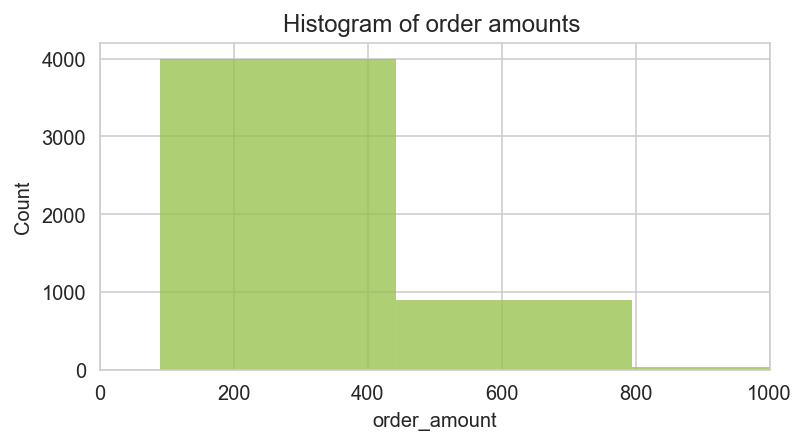

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

#Plotting histogram of prices
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (6, 3)})
hist=sns.histplot(df['order_amount'],bins=2000,color='#95BF47') #Shopify colors!
hist.set( xlim= (0,1000),title = "Histogram of order amounts ", ylabel = "Count")
print("")

[Text(0.5, 1.0, 'Boxplot of order amounts '), Text(0.5, 0, 'Prices')]

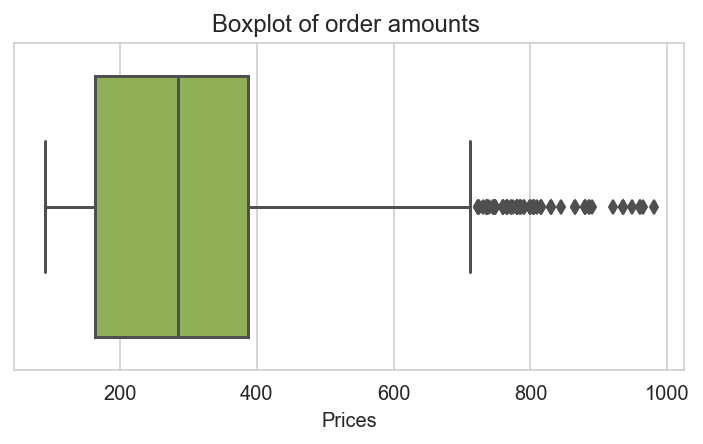

In [152]:
bx = sns.boxplot(x=df.loc[df["order_amount"] <= 1000]["order_amount"], color="#95BF47")
bx.set(title="Boxplot of order amounts ", xlabel="Prices")


#### Alternative Metrics

Instead of the mean, an alternative we can use here is the median. The median is less sensitive to outliers, so will give us a more accurate result in this scenario when our data is skewed. This is the metric I would report for this dataset.

In [144]:
print(
    f"The median price of shoes sold is ${np.median(df['order_amount'])}. I believe that this is a better estimate for average prices than the mean."
)


The median price of shoes sold is $284.0. I believe that this is a better estimate for average prices than the mean.


Alternatively, we can set decision rules to classify orders as those made by individuals vs those probably made by resellers and report separate AOVs for both. For example, we could assume that no individual buyer is buying more than 10 shoes at once, so we can classify all orders with items less or equal to 10 as those coming from an individual buyer, and calculate the AOV of all such orders. Given that the AOV is meant to provide insights regarding customer behavior, I think its best to prioritize those orders that reflect the the majority of the customer base. 